In [1]:
from PIL import Image
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
import seaborn as sns #helps in visualising data

In [2]:
training_labels="dataset/train_label.pkl"
train_images="dataset/train_image.pkl"
test_images="dataset/test_image.pkl"

LOADING AND VISUALISING DATA

In [3]:
file_objects=[]
with (open(train_images,"rb")) as openfile: #from stackoverflow and pickle docs
    while True:
        try:
            file_objects.append(pickle.load(openfile))
        except EOFError:
            break
    

In [4]:
print(len(file_objects))
print(len(file_objects[0]))
print(type(file_objects[0][1]))
print(len(file_objects[0][1]))
print(type(file_objects[0][1][1]))  


1
8000
<class 'list'>
784
<class 'int'>


As seen, the data contains 8000 lists of 784 ints, that is 28*28, hence its a reasonable assumption that these are pixel values, however we will visualise to confirm the same. 
After checking the output of print (file_objects[0][1]), the values range from 0 to 255 hence the assumption is true.
Now, we need to check if 8000 labels are present or not

In [5]:
file_label_objects=[]
with (open(training_labels,"rb")) as openfile: #from stackoverflow and pickle docs
    while True:
        try:
            file_label_objects.append(pickle.load(openfile))
        except EOFError:
            break

In [6]:
len(file_label_objects[0])

8000

So we have 8000 training labels

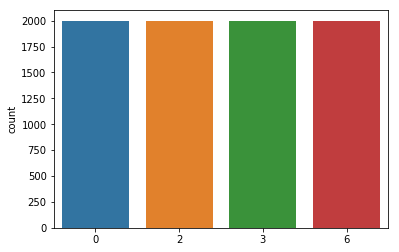

In [7]:
train_labels=file_label_objects[0]
input_class_graph=sns.countplot(train_labels)

so data is evenly distributed, and there are 4 classes, now i will visualise image , and we will do mapping of classes from 0,2,3,6 to 0,1,2,3. It will result in less size of one hot encoded vectors.

In [8]:
train_images=file_objects[0]
for i in range(len(train_labels)):
    if (train_labels[i] == 2):
        train_labels[i]=1
    elif (train_labels[i]  == 3):
        train_labels[i]=2
    elif (train_labels[i]  == 6):
        train_labels[i]=3
     
      

In [9]:
print(train_labels[7000])

3


In [10]:
#making a pandas dataframe, easier to handle stuff
train_df=pd.DataFrame(train_images)

In [11]:
train_df=train_df.values.reshape(-1,28,28,1)


3

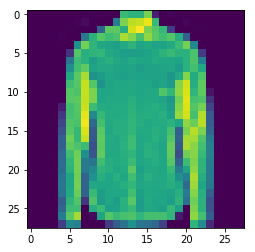

In [12]:
g=plt.imshow(train_df[7007][:,:,0])
train_labels[7007]





# after various iterations, it appears as if these are different type of clothings, although i feel class 6 has some common attributes with other classes.

SO we have classes like tees, pullover, dresses, shirt. To me, it appears as if shirt class can be confused with others

In [72]:
#to create a validation set, as the labels are in a sequential manner, the inbuilt function(keras) will not randomise and pick last few values, hence validation set wont be generalised, so I'll use sklearn for the same
from sklearn.model_selection import train_test_split
XTraining, XValidation, YTraining, YValidation = train_test_split(train_df,train_labels,stratify=train_labels,test_size=0.2)



In [73]:
#now the time to create model, I'll be using Keras to create a CNN
#for one hot encodingx importing 'to categorical'
from keras.utils.np_utils import to_categorical 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix

#one hot encoding
YTraining = to_categorical(YTraining)
YValidation = to_categorical(YValidation)

Now we create a CNN architecture
Regarding the layers:
Conv2d: basically the learnable filters with 3*3 kernel size in this case
MaxPool2D: acts as a downsampling filters, chooses max value among neighboring pixels, more global features can be learnt
Dropout: for regularisation(to reduce overfitting)
Relu, Softmax are used as activations
BatchNormalisation for quicker training
Flatten to make use of fully connected layer after convolutional layers. Dense layer is the classifier layer

In [46]:
model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu',
                 input_shape = (28, 28, 1)))
model.add(BatchNormalization())
model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

As the essence of image category remains same even if images are altered in terms of shifting,zooming,tilting in this case, I will apply these standard data augmentation techniques

In [47]:
datagen = ImageDataGenerator(zoom_range = 0.1,
                            height_shift_range = 0.1,
                            width_shift_range = 0.1,
                            rotation_range = 10,horizontal_flip=True,vertical_flip=True,
    )

In [48]:
model.compile(loss='categorical_crossentropy', optimizer = Adam(lr=1e-3), metrics=["accuracy"]) # adam as optimiser, crossentropy log loss function


In [49]:
#learning rate annealing, to slow down learning rate on plateau, so that the model can coverge to more precise point
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [50]:
hist = model.fit_generator(datagen.flow(XTraining, YTraining, batch_size=16),
                            steps_per_epoch=600,
                           epochs=20,
                           verbose=1,
                           validation_data=(XValidation, YValidation), 
                           callbacks=[learning_rate_reduction])

Epoch 1/20
600/600 [==============================] - 21s 35ms/step - loss: 0.9972 - acc: 0.5864 - val_loss: 0.6504 - val_acc: 0.7338
Epoch 2/20
600/600 [==============================] - 18s 29ms/step - loss: 0.7705 - acc: 0.6743 - val_loss: 0.5904 - val_acc: 0.7594
Epoch 3/20
600/600 [==============================] - 19s 32ms/step - loss: 0.7067 - acc: 0.7114 - val_loss: 0.5990 - val_acc: 0.7550
Epoch 4/20
600/600 [==============================] - 21s 34ms/step - loss: 0.6941 - acc: 0.7157 - val_loss: 0.5580 - val_acc: 0.7937
Epoch 5/20
600/600 [==============================] - 20s 34ms/step - loss: 0.6696 - acc: 0.7314 - val_loss: 0.7692 - val_acc: 0.7075
Epoch 6/20
600/600 [==============================] - 21s 35ms/step - loss: 0.6441 - acc: 0.7439 - val_loss: 0.4781 - val_acc: 0.8044
Epoch 7/20
600/600 [==============================] - 20s 33ms/step - loss: 0.6322 - acc: 0.7471 - val_loss: 0.4934 - val_acc: 0.7994
Epoch 8/20
600/600 [==============================] - 24s 39ms

In [51]:
model.compile(loss='categorical_crossentropy', optimizer = Adam(lr=1e-4), metrics=["accuracy"]) # adam as optimiser, crossentropy log loss function

hist = model.fit_generator(datagen.flow(XTraining, YTraining, batch_size=8),
                            steps_per_epoch=600,
                           epochs=40,
                           verbose=1,
                           validation_data=(XValidation, YValidation), 
                           callbacks=[learning_rate_reduction])

Epoch 1/40
600/600 [==============================] - 19s 32ms/step - loss: 0.4740 - acc: 0.8154 - val_loss: 0.4088 - val_acc: 0.8500
Epoch 2/40
600/600 [==============================] - 14s 24ms/step - loss: 0.4765 - acc: 0.8213 - val_loss: 0.3992 - val_acc: 0.8525
Epoch 3/40
600/600 [==============================] - 15s 24ms/step - loss: 0.4685 - acc: 0.8198 - val_loss: 0.4085 - val_acc: 0.8456
Epoch 4/40
600/600 [==============================] - 19s 32ms/step - loss: 0.4661 - acc: 0.8175 - val_loss: 0.3860 - val_acc: 0.8588
Epoch 5/40
600/600 [==============================] - 14s 23ms/step - loss: 0.4567 - acc: 0.8235 - val_loss: 0.3872 - val_acc: 0.8588
Epoch 6/40
600/600 [==============================] - 15s 25ms/step - loss: 0.4719 - acc: 0.8148 - val_loss: 0.3928 - val_acc: 0.8519
Epoch 7/40
600/600 [==============================] - 17s 29ms/step - loss: 0.4577 - acc: 0.8237 - val_loss: 0.3936 - val_acc: 0.8531

Epoch 00007: ReduceLROnPlateau reducing learning rate to 4.99

As now the learning rate is reduced to 1e-5, because of encountering plateaus again and again, it can be concluded that the model has more or less converged to the optimum. Now we will try to see what classes are most confused.

In [54]:
final_loss, final_acc = model.evaluate(XValidation, YValidation, verbose=0)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))

Final loss: 0.3950, final accuracy: 0.8500


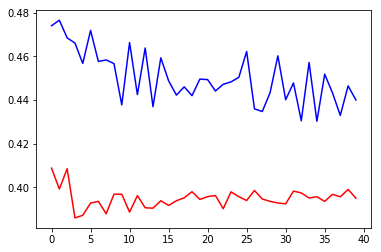

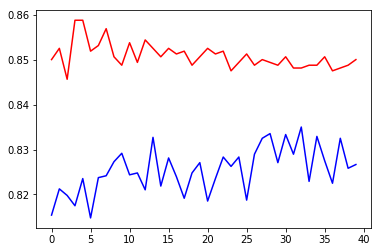

In [55]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['acc'], color='b')
plt.plot(hist.history['val_acc'], color='r')
plt.show()

In [76]:
y_hat = model.predict(XValidation)
y_pred = np.argmax(y_hat, axis=1)
y_true = np.argmax(YValidation, axis=1)
y_true.shape

(1600,)

In [77]:
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[314   8  15  63]
 [  2 343   2  53]
 [  4   2 377  17]
 [ 17  20  14 349]]


Here, it can be clearly seen how all the classes are confused with class 3, i.e. class 6 of shirts.

Initially, when I was analysing the class distribution and visualising data, thus very fact was observed that the class 6 can be confused with other classes. Intuitively, given that the input images didn't have a resolution that buttons and features like shirt pockets can be recognised, it is very likely that shirt can be confused with a tshirt or pullover, which seems to be the case here.
If we disregard class 6 of shirts, we get an accuracy of 92.48% using accuracy=(TP/(TP+FP)),
which falls to about 86% when we consider class 6
